In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

















In [11]:
# --- Step 1: Data Loading and Initial Preparation ---
print("Loading data...")
store_df = pd.read_csv('store.csv')
train_df = pd.read_csv('train.csv', low_memory=False)


# Merge the two dataframes on the 'Store' column
df = pd.merge(train_df, store_df, on='Store')

print("Data loaded and merged.")
print(df.head())

Loading data...
Data loaded and merged.
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                  


Preprocessing data for Store 1...


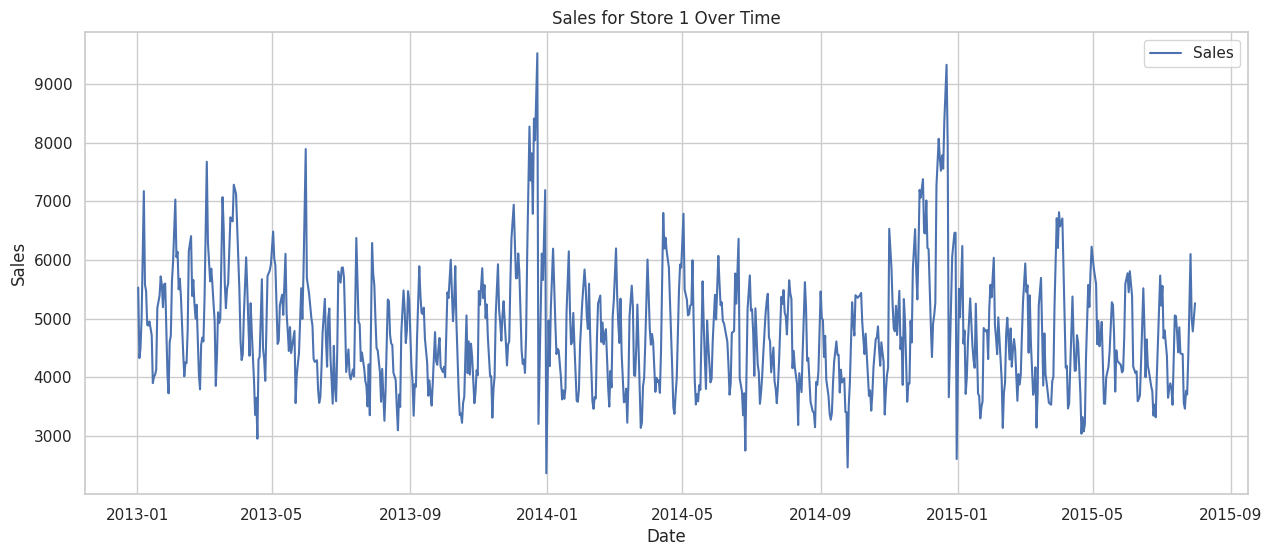

In [12]:
# --- Step 2: Data Preprocessing for a Single Store ---
print("\nPreprocessing data for Store 1...")
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter for one store (e.g., Store 1) and only when it was open and had sales
store1_df = df[(df['Store'] == 1) & (df['Open'] == 1) & (df['Sales'] > 0)].copy()

# Sort by date
store1_df.sort_values(by='Date', inplace=True)

# Set plot style
sns.set(style="whitegrid")

# Plot sales over time
plt.figure(figsize=(15, 6))
plt.plot(store1_df['Date'], store1_df['Sales'], label='Sales')
plt.title('Sales for Store 1 Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [13]:

# --- Step 3: Prophet Model (Original) ---
print("\n--- Training Original Prophet Model ---")

# Prepare the dataframe
prophet_df = store1_df[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

# Split data for evaluation (last 90 days for testing)
train_prophet = prophet_df.iloc[:-90]
test_prophet = prophet_df.iloc[-90:]

# Create a dataframe for holidays
holidays = pd.DataFrame({
    'holiday': 'StateHoliday',
    'ds': store1_df[store1_df['StateHoliday'] != '0']['Date'],
    'lower_window': 0,
    'upper_window': 1,
})


--- Training Original Prophet Model ---


In [14]:

### IMPROVEMENT 1: Enable Yearly Seasonality ###
# We explicitly enable yearly_seasonality because retail data almost always has it.
print("Initializing and fitting the original Prophet model with yearly_seasonality=True...")
model_prophet = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    daily_seasonality=True
)
model_prophet.fit(train_prophet)

### FIX: Generate a forecast for the specific dates in our dataset ###
# The model is trained, now we create a dataframe with all the dates we need a forecast for.
# This ensures we have predictions for the gappy dates in our test set.
future_prophet = prophet_df[['ds']] # Use all dates from the original filtered data

# Generate forecast for these specific dates
forecast_prophet = model_prophet.predict(future_prophet)

# --- Step 4: ARIMA Model ---
print("\n--- Training ARIMA Model ---")

# Prepare data for ARIMA
arima_df = store1_df.set_index('Date')['Sales']

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8i90z5rs/l_xcwwaz.json


Initializing and fitting the original Prophet model with yearly_seasonality=True...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8i90z5rs/tmgrg1n6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31437', 'data', 'file=/tmp/tmp8i90z5rs/l_xcwwaz.json', 'init=/tmp/tmp8i90z5rs/tmgrg1n6.json', 'output', 'file=/tmp/tmp8i90z5rs/prophet_model5we59viw/prophet_model-20250928171738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Training ARIMA Model ---


Displaying ACF and PACF plots to help determine ARIMA order...


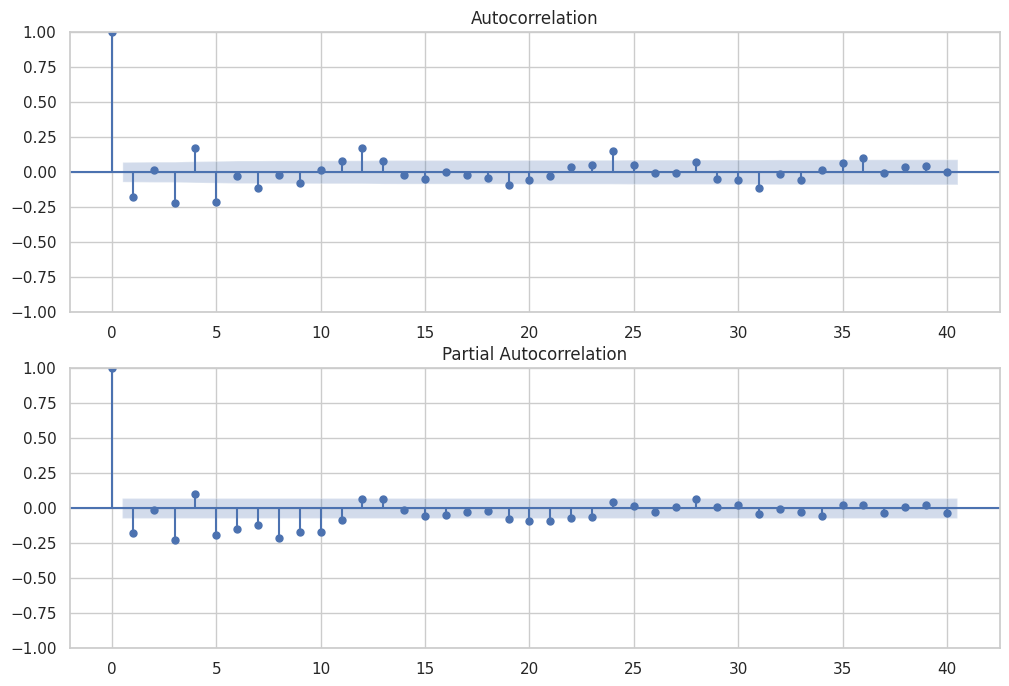

Performing walk-forward validation for ARIMA(5,1,0)... this may take a moment.
ARIMA predictions are complete.


In [15]:
### IMPROVEMENT 2: Choosing ARIMA Order with ACF/PACF Plots ###
# These plots help us determine the p and q values for the ARIMA model.
# We plot the differenced series because our model uses d=1 (for stationarity).
print("Displaying ACF and PACF plots to help determine ARIMA order...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Plot ACF
plot_acf(arima_df.diff().dropna(), lags=40, ax=ax1)
# Plot PACF
plot_pacf(arima_df.diff().dropna(), lags=40, ax=ax2)
plt.show()

# Split data into training and testing sets
train_arima, test_arima = arima_df.iloc[:-90], arima_df.iloc[-90:]

# Walk-forward validation for ARIMA
print("Performing walk-forward validation for ARIMA(5,1,0)... this may take a moment.")
history = [x for x in train_arima]
predictions_arima = []

for t in range(len(test_arima)):
    model_arima = ARIMA(history, order=(5, 1, 0))
    model_fit = model_arima.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = test_arima.iloc[t]
    history.append(obs)

print("ARIMA predictions are complete.")

In [16]:
# --- Step 5: Prophet Model with External Regressor (Promo) ---
print("\n--- Training Prophet Model with 'Promo' as an External Regressor ---")


--- Training Prophet Model with 'Promo' as an External Regressor ---


In [17]:
### IMPROVEMENT 3: Add an External Regressor to Prophet ###
# We add the 'Promo' column to see if it improves the forecast.
prophet_df_plus = store1_df[['Date', 'Sales', 'Promo']].rename(columns={'Date': 'ds', 'Sales': 'y'})

# Split data
train_plus = prophet_df_plus.iloc[:-90]
test_plus = prophet_df_plus.iloc[-90:]

# Initialize the model and add the regressor
model_prophet_plus = Prophet(yearly_seasonality=True, daily_seasonality=True)
model_prophet_plus.add_regressor('Promo')

# Fit the model on the training data which includes the 'Promo' column
print("Fitting Prophet model with 'Promo' regressor...")
model_prophet_plus.fit(train_plus)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8i90z5rs/2scen8qj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8i90z5rs/b1kprcyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8915', 'data', 'file=/tmp/tmp8i90z5rs/2scen8qj.json', 'init=/tmp/tmp8i90z5rs/b1kprcyw.json', 'output', 'file=/tmp/tmp8i90z5rs/prophet_modeldrmgpebd/prophet_model-20250928171758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fitting Prophet model with 'Promo' regressor...


In [18]:
### FIX: Create a future dataframe that already contains the known 'Promo' values ###
# For prediction, Prophet needs a dataframe with the dates ('ds') and the values
# of the regressor ('Promo') for those dates. The `prophet_df_plus` dataframe
# already contains this for our entire historical + test period.
future_plus = prophet_df_plus[['ds', 'Promo']]

# Now, predict using this dataframe that has no NaNs in the 'Promo' column.
forecast_plus = model_prophet_plus.predict(future_plus)
print("Prophet model with regressor is ready.")


Prophet model with regressor is ready.



--- Final Model Comparison ---
ARIMA(5,1,0) RMSE: 603.14 | MAPE: 10.20%
Prophet (Original) RMSE: 769.21 | MAPE: 15.33%
Prophet (+Promo) RMSE: 524.18 | MAPE: 9.66%

Plotting all forecasts against actual sales...


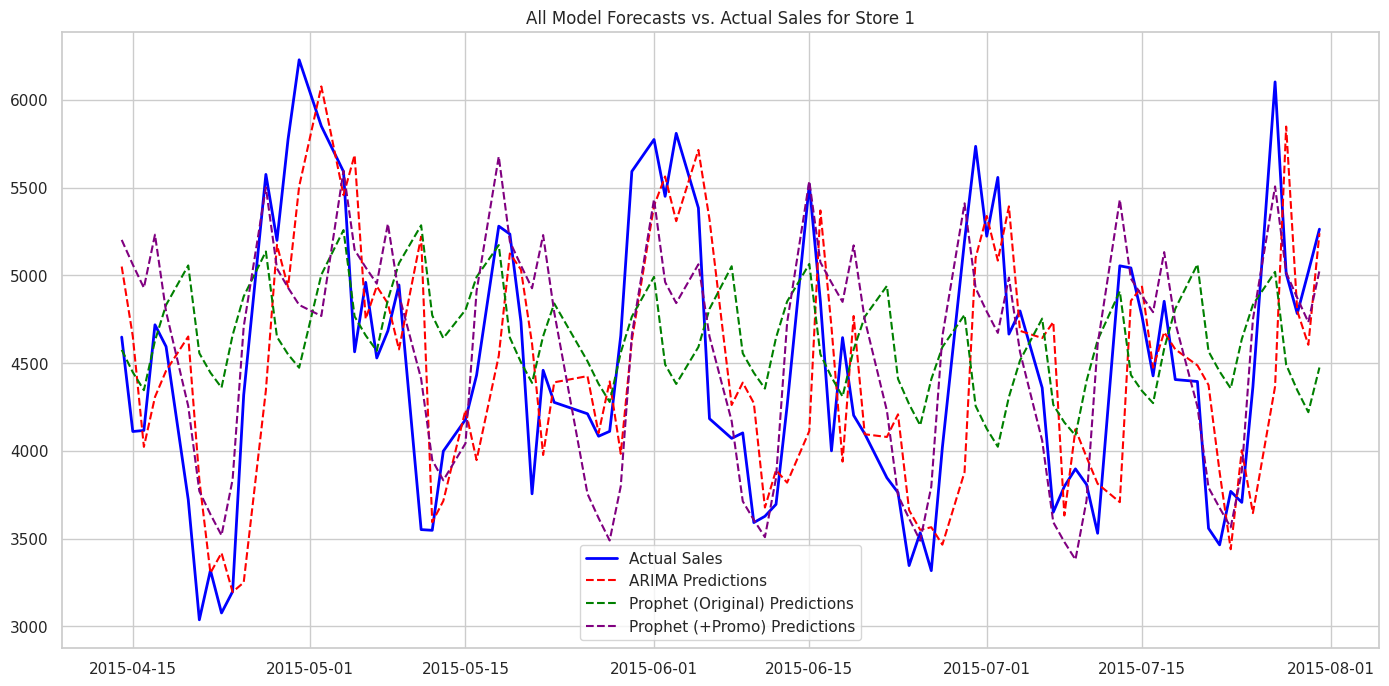

In [19]:
# --- Step 6: Final Evaluation and Comparison ---
print("\n--- Final Model Comparison ---")

# Align Prophet predictions with the test set dates
predictions_prophet = forecast_prophet.set_index('ds').loc[test_arima.index]['yhat']
predictions_prophet_plus = forecast_plus.set_index('ds').loc[test_arima.index]['yhat']

# Calculate evaluation metrics for all models
# ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_arima.values, predictions_arima))
mape_arima = np.mean(np.abs((test_arima.values - predictions_arima) / test_arima.values)) * 100

# Prophet (Original)
rmse_prophet = np.sqrt(mean_squared_error(test_arima.values, predictions_prophet))
mape_prophet = np.mean(np.abs((test_arima.values - predictions_prophet) / test_arima.values)) * 100

# Prophet (with Promo Regressor)
rmse_prophet_plus = np.sqrt(mean_squared_error(test_arima.values, predictions_prophet_plus))
mape_prophet_plus = np.mean(np.abs((test_arima.values - predictions_prophet_plus) / test_arima.values)) * 100

# Print results
print(f"ARIMA(5,1,0) RMSE: {rmse_arima:.2f} | MAPE: {mape_arima:.2f}%")
print(f"Prophet (Original) RMSE: {rmse_prophet:.2f} | MAPE: {mape_prophet:.2f}%")
print(f"Prophet (+Promo) RMSE: {rmse_prophet_plus:.2f} | MAPE: {mape_prophet_plus:.2f}%")


# Visualize the comparison
print("\nPlotting all forecasts against actual sales...")
plt.figure(figsize=(17, 8))
plt.plot(test_arima.index, test_arima.values, label='Actual Sales', color='blue', linewidth=2)
plt.plot(test_arima.index, predictions_arima, color='red', linestyle='--', label='ARIMA Predictions')
plt.plot(test_arima.index, predictions_prophet, color='green', linestyle='--', label='Prophet (Original) Predictions')
plt.plot(test_arima.index, predictions_prophet_plus, color='purple', linestyle='--', label='Prophet (+Promo) Predictions')
plt.title('All Model Forecasts vs. Actual Sales for Store 1')
plt.legend()
plt.show()
